<a href="https://colab.research.google.com/github/tannerhonnef/adleotwh/blob/main/assignment1_twh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

Work through the assignment 1 notebook, and use this notebook to provide your answers. 

To submit the assignment, you will need to use GitHub.

Using your own GitHub profile:

- Create a private repository called adleoxyz, where the xyz part is replaced with your initials. Note the lower case and the formatting. Please maintain that. If you have only 2 initials or more than 3, please use them.
- Add all three instructors as collaborators to your private repository

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment1_xyz.ipynb, with xyz again replaced by your initials.

# Answers to the theoretical questions

Please provide your answers to questions 1-4 here

**Answer to Q1)**

**Part a - For greyscale image**

First layer learnable parameters: 10,001,000

Second layer learnable parameters: 10,010

**Part b - For multi-spectral image**

First layer learnable parameters: 70,001,000

Second layer learnable parameters: 70,010


**Part c - tensor shapes**

For multi-spectral image

- First layer weight and bias shapes that transform the input to the hidden features: First layer weight is the number of pixels (100x100) in the previous example x the number of bands.  The bias is the number of nodes in the second layer which was 1000 in the previous example.

- Second layer weight and bias shapes that map from the hidden features to output classes: The second layer weight is the number of nodes times the number of output categories (1000x10) in the previous example.  The bias is the number of nodes which is 1000 in the previous example.

**Answer to Q2**
There has to be nonlinear activation functions in DNNs because values need to be "squased" so they fit into a given range either 0,1 or -1,1 depending on the function.  These are helpful because they compress data and reduce the effects of very large and very small values on the dataset.


**Answer to Q3**
One reason why ReLu is preferred in modern architectures over tanh or the sigmoid function is because it does not squash the data like tanh and sigmoid which put large values very close to each other.  The graph of ReLu is a line so the data will remain linear and the data will remain mostly unchanged which helps when considering optimization.  Another advantage of ReLu is that it is simple and only transforms values below 0 to zero and any values greater than 0 are plotted accordingly.  The graphs of sigmoid and tanh are exponential which is more complicated and does not allow for optimization as easily as ReLu. 

**Answer to Q4** Shuffling is used during training to make sure that a representative sample is being used from the entire dataset. If shuffling were not used in training, the training would yield a very skewed result as the samples wouldn't be well represented.  Shuffling is not common in the test and validation data because the data can only be used once and it is supposed to be an unchanged representation of the population.  By keeping the samples in the given order the model will have unseen data that has not been changed before evaluation. Optimization is used in training and is not used during evaluation.

# Coding Assignment

Follow the instructions below to complete your coding assignment. 

Run the code below unchanged, unless otherwise indicated. 

## Static code 1

Run unchanged

Mount drive and run imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

## Variables to set

- Model save path: Modify 'save_dir' to the path to your already downloaded MNIST dataset (from the main notebook).

In [3]:
save_dir = "/content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/"

## Static code 2

### Transforms and loads (Steps 1.1-1.5)

Necessary transforms - run unchanged


In [4]:
mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

Load and split

In [5]:
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=False,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples, 
                                                       n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/clarkFiles/dsci215/assignment1/MNIST/raw



Make iterable

In [6]:
# this cell has been changed - added train_bsize line
train_bsize = 25

train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

### Metrics and some other necessary functions

In [7]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = Variable(x).to(device)
        y = Variable(y).to(device)

        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable automatic differentiation as we don't do optimization on eval.
    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = Variable(x).to(device)
            y = Variable(y).to(device)

            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


## Task 1: Adjust the model

Modify your MLP as required

In [8]:
# Modify this cell
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, drop_rate, input_features, output_features, bn_features):
        super(MLP, self).__init__()
        
        self.mlp_block = nn.Sequential(nn.Linear(input_dim, output_dim, bias=False),
                                       nn.LeakyReLU(),
                                       nn.Linear(input_features, output_features),
                                       nn.LeakyReLU(),
                                       nn.BatchNorm1d(bn_features),
                                       nn.Dropout(drop_rate),
                                       nn.Linear(output_features, output_dim))



    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        # h_1 = F.relu(self.input_fc(x))

        # # h_1 = [batch size, 250]
        # h_2 = F.relu(self.hidden_fc(h_1))
        # #  h_2 = [batch size, 100]
        # y_pred = self.output_fc(h_2)


        y_pred = self.mlp_block(x)

        return y_pred
      # Add your code here.
  

If you are struggling to get it working, here is a commented out version of the example model that you can run and adapt.  You might want to use some of the other 3 examples that we suggested for structuring the model class

In [ ]:
# class MLP(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MLP, self).__init__()
        
#         self.input_fc = nn.Linear(input_dim, 250)
#         self.hidden_fc = nn.Linear(250, 100)
#         self.output_fc = nn.Linear(100, output_dim)

#     def forward(self, x):
        
#         # x is a batch of images with the shape: [batch size, height, width]
#         batch_size = x.shape[0]
        
#         # First, we have to convert the 2D tensor (H and W) in 
#         # an Mnist image, into a 1D tensor so that it can be fed into the first 
#         # Linear layer, and we do that using the view().
#         x = x.view(batch_size, -1)

#         # x is now have the shape: [batch size, (height * width)]

#         # we pass input through each layer and the activation function in order, finally 
#         # returning the output to give us our prediction for that image.
#         h_1 = F.relu(self.input_fc(x))

#         # h_1 = [batch size, 250]
#         h_2 = F.relu(self.hidden_fc(h_1))

#         # h_2 = [batch size, 100]
#         y_pred = self.output_fc(h_2)

#         # y_pred = [batch size, output dim]

#         return y_pred

Define the parameters needed to run the model

In [33]:
input_dim = 28*28
initial_lr = 0.005   # Hyper-parameter that you can change for optional part
num_epochs = 20    # Hyper-parameter that you can change for optional part
train_bsize = 50   # training batch size--can change for optional part

# new variables
hidden_dims = 7 # provide integer or list of integers, 
              # depending on the coding choices you make
output_dim = 250
drop_rate = 0.2  # choose a number in the range [0,1] for your dropout 
input_features = 250
output_features = 100
bn_features = 100
# Look on the web and experiment yourself to find a good rate


## Task 2: Show your work

Run and print the model

In [34]:
# Don't change this cell
model = MLP(input_dim, hidden_dims, output_dim, drop_rate, input_features, output_features, bn_features)
#model = MLP(input_dim, output_dim)
print(model)

MLP(
  (mlp_block): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=250, bias=True)
  )
)


Show the number of parameters in the model

In [35]:
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 246,550 trainable parameters


Optimizer, loss criterion, and GPU/CPU switch

In [36]:
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Train the model

In [37]:
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    #simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 0.480 | Train Acc: 85.85%
	 Val. Loss: 0.162 |  Val. Acc: 94.97%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.240 | Train Acc: 92.73%
	 Val. Loss: 0.128 |  Val. Acc: 95.88%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.200 | Train Acc: 93.91%
	 Val. Loss: 0.104 |  Val. Acc: 96.72%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.172 | Train Acc: 94.78%
	 Val. Loss: 0.088 |  Val. Acc: 97.10%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.159 | Train Acc: 95.17%
	 Val. Loss: 0.087 |  Val. Acc: 97.22%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.146 | Train Acc: 95.54%
	 Val. Loss: 0.085 |  Val. Acc: 97.23%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.136 | Train Acc: 95.85%
	 Val. Loss: 0.073 |  Val. Acc: 97.57%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 0.128 | Train Acc: 96.16%
	 Val. Loss: 0.063 |  Val. Acc: 97.98%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 0.121 | Train Acc: 96.35%
	 Val. Loss: 0.064 |  Val. Acc: 98.02%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 0.120 | Train Acc: 96.40%
	 Val. Loss: 0.061 |  Val. Acc: 98.10%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 29s
	Train Loss: 0.115 | Train Acc: 96.57%
	 Val. Loss: 0.062 |  Val. Acc: 98.18%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 29s
	Train Loss: 0.111 | Train Acc: 96.65%
	 Val. Loss: 0.055 |  Val. Acc: 98.30%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 29s
	Train Loss: 0.105 | Train Acc: 96.80%
	 Val. Loss: 0.056 |  Val. Acc: 98.20%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 29s
	Train Loss: 0.105 | Train Acc: 96.79%
	 Val. Loss: 0.064 |  Val. Acc: 98.08%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 28s
	Train Loss: 0.101 | Train Acc: 97.02%
	 Val. Loss: 0.056 |  Val. Acc: 98.43%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 29s
	Train Loss: 0.099 | Train Acc: 96.99%
	 Val. Loss: 0.063 |  Val. Acc: 97.90%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 29s
	Train Loss: 0.100 | Train Acc: 97.00%
	 Val. Loss: 0.061 |  Val. Acc: 98.20%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 29s
	Train Loss: 0.097 | Train Acc: 97.11%
	 Val. Loss: 0.055 |  Val. Acc: 98.23%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 30s
	Train Loss: 0.094 | Train Acc: 97.19%
	 Val. Loss: 0.054 |  Val. Acc: 98.32%


Training:   0%|          | 0/2160 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 29s
	Train Loss: 0.097 | Train Acc: 97.04%
	 Val. Loss: 0.060 |  Val. Acc: 98.17%


Plot the results

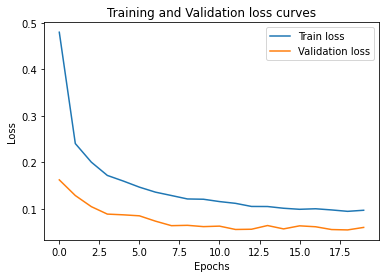

In [38]:
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Evaluate the performance

In [39]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

Test Loss: 0.056 | Test Acc: 98.27%


Show the matrix

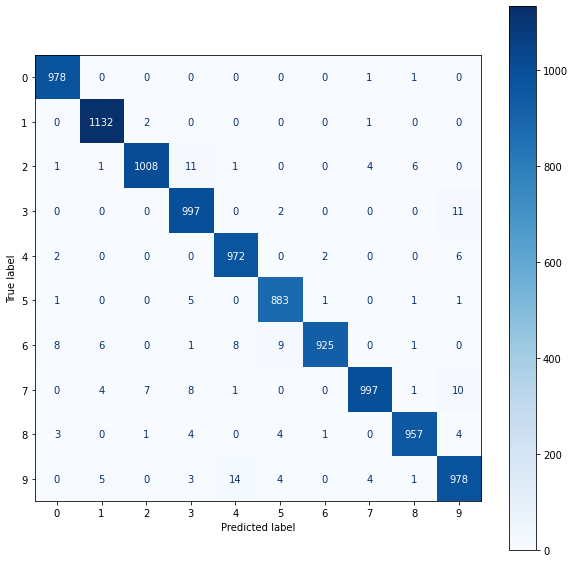

In [40]:
# copied code from the assignment directions to here to create the confusion matrix

def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_loader, device)

# We take the predicted labels using the index of the highest predicted probability.
pred_labels = torch.argmax(probs, 1)

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels)

## Optional Task 3

Use the model above and the parameters for batch size, learning rate, and dropout to evaluate model performance. Repeat using the code above from Task 2: Show your work. Provide the outputs (loss curves, performance metrics), from the best and worst results in the cells below. 

### Best result

This is an example of a run of the model with 20 epochs and the training batch size set to 50.  The learning rate in this was 0.001.  The test accuracy was 98.42% after this run.  This model yielded a test loss of 0.048 and a test accuracy of 98.45%.  The number of epochs in this model in an effort to get the best result possible.

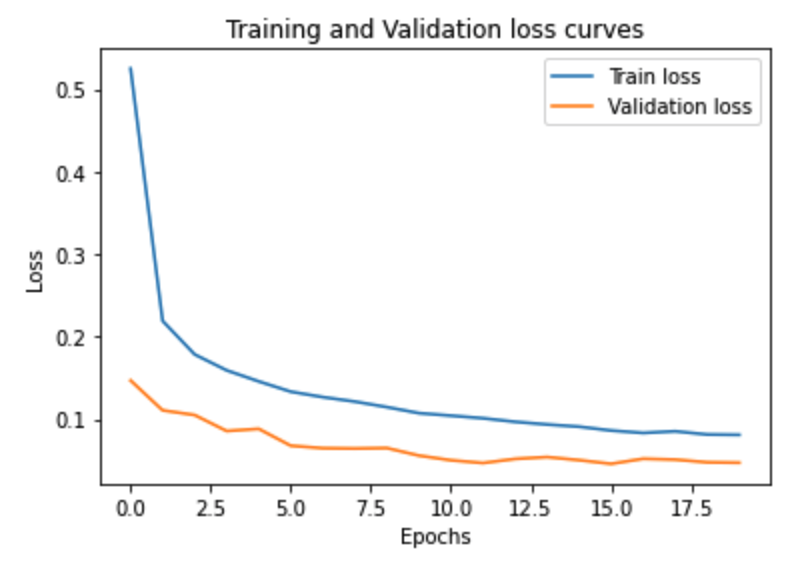

### Worst result

The worst result below had a learning rate that was far too large which caused the extreme oscillation of the validation loss.  The learning rate was 0.05 when most of the rest of the models were run with a learning rate of 0.001.  The number of epochs was reduced for the sake of time in computing the model.

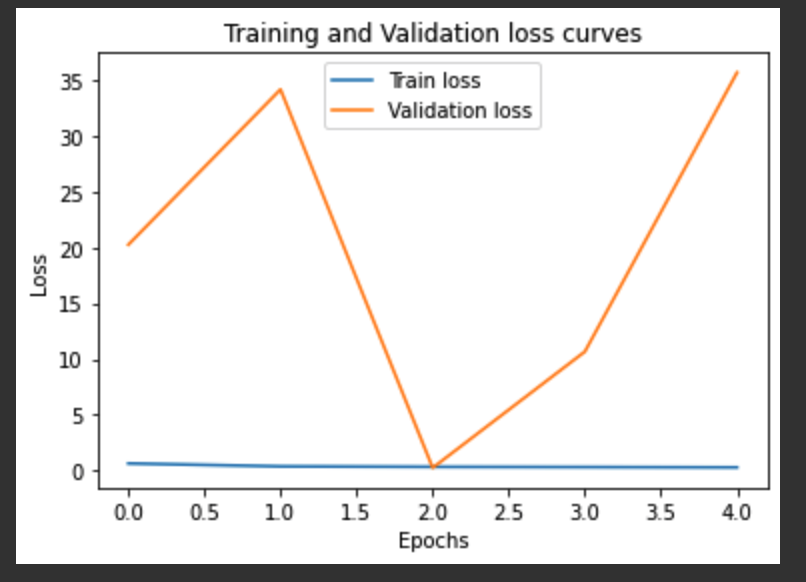